In [13]:
#multinet python library
import uunet.multinet as ml
import sqlite3
import pandas as pd

# Replace with your actual database file path
db_file_path = "/Users/harunpirim/Documents/GitHub/multilayer_polarization/data/csvyerine2.db"

# Establish a connection to the SQLite database
conn = sqlite3.connect(db_file_path)

# Define the table name you want to read
table_name = "metadata"

# Read the table data into a pandas DataFrame
metadata = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

# Now, 'metadata' contains the data from the 'metadata' table

# Close the database connection when you're done
#conn.close()

metadata.head()

# Create a cursor object
cursor = conn.cursor()

# Get a list of table names in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Extract table names from the result
table_names = [table[0] for table in tables]

# Print the table names 
print(table_names)

# Filter table names that start with "sup"
sup_tables = [table for table in table_names if table.startswith("sup")]
# Filter table names that start with "unsup"
unsup_tables = [table for table in table_names if table.startswith("unsup")]

# Print the filtered table names
print(sup_tables, unsup_tables)

['sup_econ', 'sup_env', 'sup_health', 'sup_imm', 'sup_sjid', 'sup_sjlab', 'sup_sjwom', 'unsup_awe', 'unsup_cam', 'unsup_gov', 'unsup_med', 'unsup_rig', 'unsup_sta', 'metadata']
['sup_econ', 'sup_env', 'sup_health', 'sup_imm', 'sup_sjid', 'sup_sjlab', 'sup_sjwom'] ['unsup_awe', 'unsup_cam', 'unsup_gov', 'unsup_med', 'unsup_rig', 'unsup_sta']


[<networkx.classes.graph.Graph object at 0x1776e0eb0>, <networkx.classes.graph.Graph object at 0x28817ae50>, <networkx.classes.graph.Graph object at 0x16ea442e0>, <networkx.classes.graph.Graph object at 0x288202370>, <networkx.classes.graph.Graph object at 0x16eaab580>, <networkx.classes.graph.Graph object at 0x16bd99ee0>, <networkx.classes.graph.Graph object at 0x169761760>]


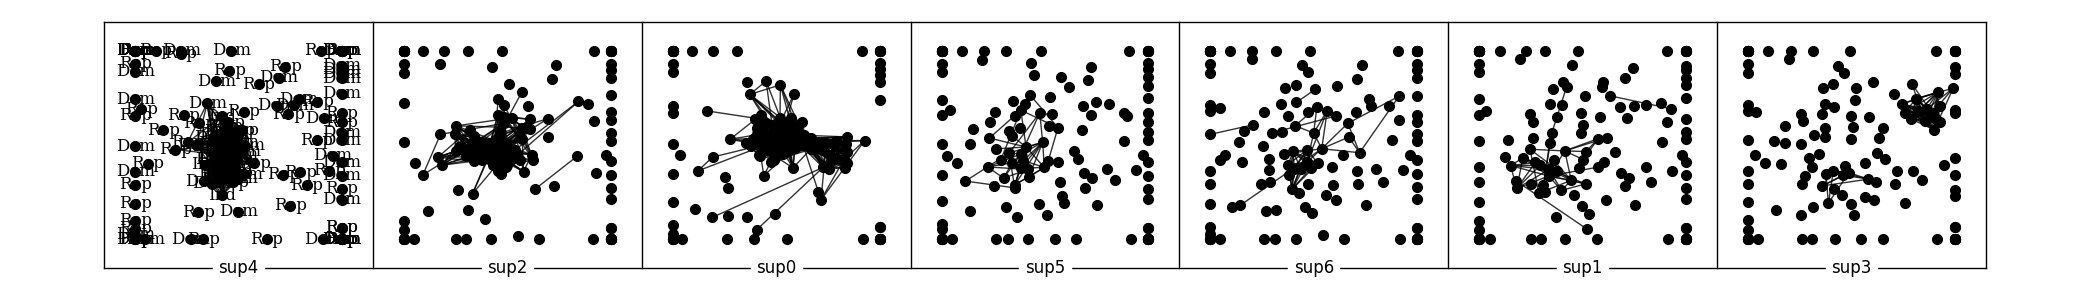

In [26]:
import sqlite3
import pandas as pd
import networkx as nx
import uunet.multinet as ml
# Define a function to construct layers
def construct_layers(type="sup"):
    layers = []  # Create an empty list to store adjacency matrices
    table_names = []  # Create a list to store table names

    # Assuming 'conn' is an established SQLite connection as shown in the previous examples

    # Get a list of table names that start with the specified type
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    all_table_names = cursor.fetchall()
    for table in all_table_names:
        table_name = table[0]
        if table_name.startswith(type):
            table_names.append(table_name)

    # Construct adjacency matrices
    for table_name in table_names:
        # Read the table data into a pandas DataFrame
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

        # Remove the first column
        df = df.iloc[:, 1:]

        # Rename columns to remove the 'X' prefix and convert to a matrix
        df.columns = [col.replace('X', '') for col in df.columns]
        adj_matrix = df.to_numpy()

        # Create a graph from the adjacency matrix
        G = nx.Graph(adj_matrix)

        # Assign the resulting graph to a list element
        layers.append(G)

    return layers

# Call the function to construct supervised layers
layers_sup = construct_layers("sup")

# 'layers_sup' is a list of networkx.Graph objects
print(layers_sup)

#construct multiplex network
mg = ml.empty() 
for i, layer in enumerate(layers_sup):
    ml.add_nx_layer(mg, layer, name=f"sup{i}")

def df(d):
    return pd.DataFrame.from_dict(d)

df(ml.edges(mg))    

# Initialize an empty list to store colors
colors = []

# Iterate through rows of the DataFrame
for index, row in metadata.iterrows():
    if row["finalParty"] == "Republican":
        colors.append(0)
    elif row["finalParty"] == "Democrat":
        colors.append(1)
    else:
        colors.append(2)

# Convert colors to labels
labels = ["Dem" if color == 1 else "Rep" if color == 0 else "Ind" for color in colors]

# Convert colors to color names
color_map = {1: "blue", 0: "red", 2: "orange"}
colornew = [color_map[color] for color in colors]

#plot multiplex network
ml.plot(mg, vertex_labels = labels)


In [31]:
#ml summary
df(ml.summary(mg))

# clusters
comm_dict = dict()
comm_dict["abacus"] = ml.abacus(mg, 4, 2) 
comm_dict["cpm"] = ml.clique_percolation(mg, 4, 2) 
comm_dict["glouvain"] = ml.glouvain(mg) 
comm_dict["infomap"] = ml.infomap(mg) 
comm_dict["mdlp"] = ml.mdlp(mg) 
comm_dict["flat_ec"] = ml.flat_ec(mg)
comm_dict["flat_nw"] = ml.flat_nw(mg)

comm = dict()
for c in comm_dict.keys():
    comm[c] = df(comm_dict[c])

In [38]:
stats = dict()
stats["method"] = comm.keys()
stats["num_comm"] = []
stats["avg_actors_per_comm"] = []
stats["avg_layers_per_comm"] = []
stats["perc_clustered_vertices"] = []
stats["overlapping"] = []
for method in stats["method"]:
    stats["num_comm"].append( comm[method].cid.nunique() ) 
    stats["avg_actors_per_comm"].append( comm[method].groupby("cid").nunique().actor.mean() )
    stats["avg_layers_per_comm"].append( comm[method].groupby("cid").nunique().layer.mean() )
    stats["perc_clustered_vertices"].append( comm[method][["actor","layer"]].drop_duplicates().shape[0] / ml.num_vertices(mg) ) 
    stats["overlapping"].append( comm[method].shape[0] /comm[method][["actor","layer"]].drop_duplicates().shape[0] ) 
df( stats )

,method,num_comm,avg_actors_per_comm,avg_layers_per_comm,perc_clustered_vertices,overlapping
0,abacus,27,5.703704,2.074074,0.180396,1.838150
1,cpm,22,9.227273,2.227273,0.182482,2.531429
2,glouvain,43,3.186047,7.000000,1.000000,1.000000
3,infomap,42,3.261905,7.000000,1.000000,1.000000
4,mdlp,43,3.186047,7.000000,1.000000,1.000000
5,flat_ec,43,3.186047,7.000000,1.000000,1.000000
6,flat_nw,43,3.186047,7.000000,1.000000,1.000000


In [42]:
#change omega values and calculate stats
stats = dict()
stats["omega"] = [0, 0.01, 0.1, 1] 
stats["num_communites"] = [] 
stats["avg_actors_per_comm"] = [] 
stats["avg_layers_per_comm"] = [] 
for om in stats["omega"]:
    clustering = df( ml.glouvain(mg, omega = om) )
    stats["num_communites"].append( clustering.cid.nunique() )
    stats["avg_actors_per_comm"].append(clustering.groupby("cid").nunique().actor.mean())
    stats["avg_layers_per_comm"].append(clustering.groupby("cid").nunique().layer.mean())
df(stats)

,omega,num_communites,avg_actors_per_comm,avg_layers_per_comm
0,0.00,701,1.368046,1.000000
1,0.01,46,5.000000,6.978261
2,0.10,43,4.953488,7.000000
3,1.00,44,3.113636,7.000000


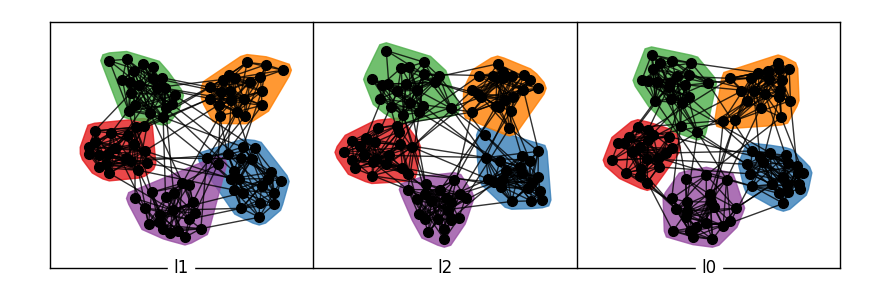

In [48]:
# generate communities
pillars = ml.generate_communities("pep", 100, 3, 5)
ml.plot(pillars['net'], com = pillars['com'], vertex_labels = [])